# Amazon Reviews recommender system

### Step.1:

Download the dataset https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

### Step-2:

In [1]:
#importing the packages 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("ratings_beauty.csv")
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,205616461,5,1369699200
1,A3JM6GV9MNOF9X,558925278,3,1355443200
2,A1Z513UWSAAO0F,558925278,5,1404691200
3,A1WMRR494NWEWV,733001998,4,1382572800
4,A3IAAVS479H7M7,737104473,1,1274227200


In [3]:
#shape of the dataset
print("There are",df.shape[0], "rows and", df.shape[1],"columns.")

There are 1048575 rows and 4 columns.


In [4]:
#info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
UserId       1048575 non-null object
ProductId    1048575 non-null object
Rating       1048575 non-null int64
Timestamp    1048575 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [5]:
df.describe(include='all')

,UserId,ProductId,Rating,Timestamp
count,1048575,1048575,1.048575e+06,1.048575e+06
unique,736653,97987,NaN,NaN
top,A3M174IC0VXOS2,B001MA0QY2,NaN,NaN
freq,278,7533,NaN,NaN
mean,NaN,NaN,4.176864e+00,1.345636e+09
std,NaN,NaN,1.306543e+00,5.567113e+07
min,NaN,NaN,1.000000e+00,9.087552e+08
25%,NaN,NaN,4.000000e+00,1.322438e+09
50%,NaN,NaN,5.000000e+00,1.362960e+09
75%,NaN,NaN,5.000000e+00,1.385856e+09


In [6]:
# Mean rating for each Product

product_rating = df.groupby('ProductId')['Rating'].mean()
product_rating.head()

ProductId
1304139212    5.000000
1304139220    5.000000
130414089X    5.000000
130414643X    4.333333
1304146537    5.000000
Name: Rating, dtype: float64

In [7]:
# Count of the number of ratings per Product

product_rating_count = df.groupby('ProductId')['Rating'].count()
product_rating_count.head()

ProductId
1304139212    1
1304139220    1
130414089X    1
130414643X    3
1304146537    1
Name: Rating, dtype: int64

In [8]:
# Un-Reliability factor

unreliability = df.groupby('ProductId')['Rating'].std(ddof = -1)
unreliability.head()

ProductId
1304139212    0.000000
1304139220    0.000000
130414089X    0.000000
130414643X    0.408248
1304146537    0.000000
Name: Rating, dtype: float64

### Step 3: Check for missing values and outliers

In [9]:
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

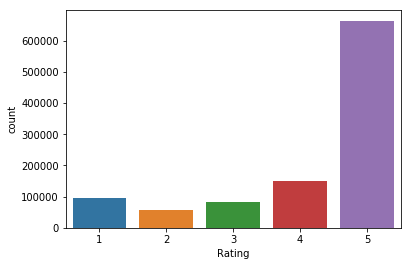

In [10]:
import seaborn as sns
sns.countplot(x='Rating',data=df)
plt.show()

In [11]:
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

In [12]:
#outlier for rating feature in the dataset

outliers = find_outliers_IQR(df['Rating'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))



number of outliers: 151374
max outlier value: 2
min outlier value: 1


In [13]:
#outlier for timestamp feature in dataset

outliers = find_outliers_IQR(df['Timestamp'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))


number of outliers: 53505
max outlier value: 1227225600
min outlier value: 908755200


In [14]:
# Data frame with calculated fields and measures

unique_products_list = df.ProductId.unique()
data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],\
                           'Count': product_rating_count[unique_products_list], \
                          'Unreliability': unreliability[unique_products_list]})
data_model.head()

,Count,Rating,Unreliability
ProductId,,,
205616461,1,5.0,0.000000
558925278,2,4.0,0.816497
733001998,1,4.0,0.000000
737104473,1,1.0,0.000000
762451459,1,5.0,0.000000


In [15]:
# Removing outliers and improbable data points

data_model = data_model[data_model.Count > 50][data_model.Count < 1001].copy()
print(data_model.shape)

(3831, 3)


In [16]:
# Normalization function to range 0 - 10

def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [17]:
data_model_norm = normalize(data_model)
data_model_norm.head()

,Count,Rating,Unreliability
ProductId,,,
9790790961,0.201913,8.001964,5.910124
B00004TMFE,0.913921,5.565655,7.601756
B00004TUBL,5.387885,9.072359,3.356747
B00004TUBV,1.275239,7.994819,5.560650
B00004U9UY,1.009564,9.342534,2.892613


### Step 4: Apply Recommendations algorithms to the dataset

In [18]:
# Setting up the model

# Recommend 20 similar items
from sklearn.neighbors import KNeighborsClassifier
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points
data_points = data_model_norm[['Count', 'Rating', 'Unreliability']].values

#Training labels
labels = data_model_norm.index.values

print("Data points: ", data_points)
print('\n')
print("Labels: ",labels)

Data points:  [[0.20191286 8.00196383 5.91012363]
 [0.91392136 5.5656547  7.60175618]
 [5.38788523 9.07235884 3.35674656]
 ...
 [1.93411265 5.64482562 7.14440077]
 [0.12752391 8.41855571 5.44145464]
 [0.36131775 3.35061775 8.75832762]]


Labels:  ['9790790961' 'B00004TMFE' 'B00004TUBL' ... 'B003H8180I' 'B003H87S0C'
 'B003H897AQ']


In [19]:
engine.fit(data_points, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

### Step 5: Give recommendations and interpret your result

In [20]:
# Enter product ID to get a list of 20 recommended items

# User entered value
product_id = 'B00004TUBL'

product_data = [data_model_norm.loc[product_id][['Count', 'Rating', 'Unreliability']].values]

recommended_products = engine.kneighbors(X=product_data, n_neighbors=20, return_distance=False)

# List of product IDs form the indexes

products_list = []

for each in recommended_products:
    products_list.append(data_model_norm.iloc[each].index)

print("Recommended products: ")
print(products_list)


Recommended products: 
[Index(['B00004TUBL', 'B0000AFUTL', 'B002TPQPEE', 'B000NWGCZ2', 'B000ODNSR0',
       'B0013TM9UQ', 'B000F35R00', 'B0018DAUKI', 'B001DKQ3O8', 'B001ET77NY',
       'B000B8FW0Y', 'B00132ZG3U', 'B000OQ2DL4', 'B0030HMQTS', 'B00178TVXG',
       'B001TJXI5U', 'B000UM2KCY', 'B000ZLVUYO', 'B002MSN3QQ', 'B000YJ2SLG'],
      dtype='object', name='ProductId')]


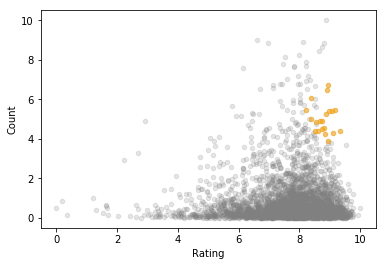

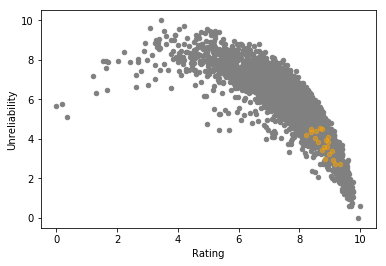

In [21]:
# Showing recommended products

ax = data_model_norm.plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.20)
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Count',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = data_model_norm.plot(kind='scatter', x='Rating', y='Unreliability', color='grey')
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Unreliability',\
                                                   color='orange', alpha=0.5, ax=ax2)
plt.show()
